In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# Import required module
import os
import subprocess

# Step 1: Instal                    l dependencies only if required
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import glob
    from tqdm import tqdm
    import seaborn as sns
    import torch
    import torchvision.models as models
    import torchvision.transforms as transforms
    from sklearn.metrics.pairwise import cosine_similarity
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv
    from scipy.stats import rankdata
    from torch.utils.data import DataLoader, Dataset
    from sklearn.feature_extraction.text import TfidfVectorizer
    from collections import defaultdict
    import random
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from torch_geometric.utils import add_self_loops
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score
    from itertools import chain
    from sklearn.manifold import TSNE

except ImportError:
    print("Installing dependencies...")

    # Install system-level dependencies
    subprocess.run(["apt-get", "update"])
    subprocess.run(["apt-get", "install", "-y", "libcairo2", "libcairo2-dev"])

    # Install Python packages
    subprocess.run(["pip", "install", "--quiet", "pycairo"])
    subprocess.run(["pip", "install", "--quiet", "torch torchvision torchaudio"])
    subprocess.run(["pip", "install", "--quiet", "torch-geometric", "torch-scatter", "torch-sparse", "torch-cluster", "torch-spline-conv"])
    subprocess.run(["pip", "install", "--quiet", "pandas", "numpy", "matplotlib", "pillow", "tqdm", "seaborn", "scipy"])
    subprocess.run(["pip", "install", "--quiet", "scikit-learn"])

    print("All dependencies installed.")

# Step 2: Save the environment to requirements.txt
subprocess.run("pip freeze > requirements.txt", shell=True)
print("Dependencies saved to requirements.txt")


/usr/local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Dependencies saved to requirements.txt


In [12]:
# Step 3: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
from tqdm import tqdm
import seaborn as sns
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from scipy.stats import rankdata
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from torch_geometric.utils import add_self_loops
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score
from itertools import chain
from sklearn.manifold import TSNE

In [13]:
# Adjust article ID format
def adjust_id(x):
    x = str(x)
    return "0" + x if len(x) == 9 else x

# Save model checkpoint
def save_checkpoint(model, optimizer, epoch, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

# Load model checkpoint
def load_checkpoint(filename, model, optimizer=None):
    checkpoint = torch.load(filename, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

In [14]:
articles = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv')
# sample_submission = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
transactions = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [15]:
# Get all paths from the image folder
all_image_paths = glob.glob("/kaggle/input/h-and-m-personalized-fashion-recommendations/images/*/*.jpg")  # Adjust if images are PNG

# Adjust the article ID and product code to be string & add "0"
articles["article_id"] = articles["article_id"].apply(lambda x: adjust_id(x))
articles["product_code"] = articles["article_id"].apply(lambda x: x[:3])

# Get all valid article IDs and create a set to store image IDs
all_image_ids = set()

for path in tqdm(all_image_paths, desc="Processing Images"):
    article_id = os.path.basename(path).split('.')[0]  # Extract image ID from filename
    all_image_ids.add(article_id)

Processing Images: 100%|██████████| 105100/105100 [00:00<00:00, 798926.63it/s]


In [16]:
# Construct full image paths and filter invalid ones
images_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/images/"
articles["path"] = articles["article_id"].apply(
    lambda x: images_path + x[:3] + "/" + x + ".jpg" if x in all_image_ids else None
)

# Filter out articles without valid images
articles_with_images = articles[articles["path"].notna()].reset_index(drop=True)

# Save the filtered articles to a new file (optional)
articles_with_images.to_csv("articles_with_images.csv", index=False)

# Debug: Check the filtered DataFrame
# print(articles_with_images.head())


In [17]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

In [18]:
# Fill missing values
customers.fillna({
    "FN": 0,
    "Active": 0,
    "club_member_status": "UNKNOWN",
    "fashion_news_frequency": "UNKNOWN",
    "age": customers["age"].median()
}, inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None": "NONE"})
customers["age_interval"] = customers["age"].apply(create_age_interval)

trasactions

In [19]:
# Adjust article_id (as did for articles dataframe)
transactions["article_id"] = transactions["article_id"].apply(lambda x: adjust_id(x))

# Filter the transactions dataset to keep only valid article IDs
transactions_filtered = transactions[transactions["article_id"].isin(set(articles_with_images["article_id"]))].reset_index(drop=True)

# Optionally save the filtered transactions dataset
transactions_filtered.to_csv("transactions_filtered.csv", index=False)


In [20]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [21]:
# Define numerical features
# Normalize numerical features
numerical_columns = [
    'product_type_no', 'colour_group_code', 'index_group_no',
    'section_no', 'garment_group_no', 'graphical_appearance_no'
]
if all(col in articles_with_images.columns for col in numerical_columns):
    scaler = MinMaxScaler()
    articles_with_images[numerical_columns] = scaler.fit_transform(articles_with_images[numerical_columns])
    articles_with_images['numerical_features'] = articles_with_images[numerical_columns].values.tolist()
else:
    raise ValueError("Error: One or more numerical columns are missing!")

In [22]:
# Define text features
if all(col in articles_with_images.columns for col in ['detail_desc', 'prod_name', 'product_type_name', 'product_group_name',
                                           'graphical_appearance_name', 'colour_group_name', 'index_name',
                                           'index_group_name', 'section_name', 'garment_group_name']):
    articles_with_images['text_data'] = (
        articles_with_images['detail_desc'].fillna('') + ' ' +
        articles_with_images['prod_name'].fillna('') + ' ' +
        articles_with_images['product_type_name'].fillna('') + ' ' +
        articles_with_images['product_group_name'].fillna('') + ' ' +
        articles_with_images['graphical_appearance_name'].fillna('') + ' ' +
        articles_with_images['colour_group_name'].fillna('') + ' ' +
        articles_with_images['index_name'].fillna('') + ' ' +
        articles_with_images['index_group_name'].fillna('') + ' ' +
        articles_with_images['section_name'].fillna('') + ' ' +
        articles_with_images['garment_group_name'].fillna('')
    )
else:
    raise ValueError("Error: One or more textual columns are missing!")

In [23]:
# Perform TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=100)
text_features_matrix = vectorizer.fit_transform(articles_with_images['text_data']).toarray()
text_features = {i: text_features_matrix[i] for i in range(len(articles_with_images))}

In [24]:
# Combine numerical and textual features
articles_with_images['combined_features'] = articles_with_images.apply(
    lambda row: np.concatenate([row['numerical_features'], text_features[row.name]]), axis=1
)

# Clustering for dynamic grouping
kmeans = KMeans(n_clusters=10, random_state=42) #lb or nb clustering to ge the num of clusters
articles_with_images['cluster'] = kmeans.fit_predict(np.stack(articles_with_images['combined_features'].values))

In [25]:
# Function to generate positive indices
def get_positive_indices(idx, product_group_name, colour_group_code, cluster_id, article_id):
    group_indices = articles_with_images[
        (articles_with_images['product_group_name'] == product_group_name) &
        (articles_with_images['colour_group_code'] == colour_group_code)
    ].index.tolist()

    if len(group_indices) < 10:
        group_indices = articles_with_images[articles_with_images['cluster'] == cluster_id].index.tolist()

    if len(group_indices) < 10 and 'transactions_filtered' in globals():
        co_purchased_ids = transactions_filtered[transactions_filtered['customer_id'].isin(
            transactions_filtered[transactions_filtered['article_id'] == article_id]['customer_id']
        )]['article_id'].unique()
        group_indices = [i for i in articles_with_images.index if articles_with_images.loc[i, 'article_id'] in co_purchased_ids]

    if not group_indices:
        return []

    return random.sample(group_indices, min(10, len(group_indices)))

articles_with_images['positive_indices'] = articles_with_images.apply(
    lambda row: get_positive_indices(row.name, row['product_group_name'], row['colour_group_code'], row['cluster'], row['article_id']),
    axis=1
)

In [26]:
def generate_hard_negatives(total_items, positive_sets, num_samples=10):
    """
    Implements HARD NEGATIVE SAMPLING (as in C-STAR).
    Selects items that are similar to positives (same product group & cluster)
    but were NOT co-purchased.
    """
    all_indices = np.arange(total_items)
    negative_indices = []

    for i, positive_set in enumerate(positive_sets):
        product_group = articles_with_images.iloc[i]['product_group_name']
        cluster_id = articles_with_images.iloc[i]['cluster']

        similar_articles = articles_with_images[
            (articles_with_images['product_group_name'] == product_group) &
            (articles_with_images['cluster'] == cluster_id) &
            (~articles_with_images.index.isin(positive_set))
        ].index.tolist()

        if len(similar_articles) >= num_samples:
            sampled_negatives = np.random.choice(similar_articles, num_samples, replace=False).tolist()
        else:
            valid_negatives = np.setdiff1d(all_indices, list(positive_set) + [i])
            sampled_negatives = np.random.choice(valid_negatives, min(num_samples, len(valid_negatives)), replace=False).tolist()

        negative_indices.append(sampled_negatives)

    return negative_indices




In [27]:
# Generate Negative Indices
total_items = len(articles_with_images)
positive_sets = articles_with_images['positive_indices'].apply(set)
articles_with_images['negative_indices'] = generate_hard_negatives(total_items, positive_sets)


data splitting

In [28]:
def geometric_distributed_sampling(ranks, rho=0.5, max_samples=300000):
    """
    Optimized Geometric Distributed Sampling (GDS) with category limit fix.
    Ensures probabilities remain valid by normalizing ranks.
    """
    # Sort transactions by rank (latest transactions get highest rank)
    sorted_indices = torch.argsort(ranks, descending=True)

    # Take only a **manageable** subset for sampling
    max_categories = min(len(ranks), 16_000_000)  # Limit to prevent exceeding `2^24`
    filtered_indices = sorted_indices[:max_categories]  # Consider only recent transactions

    # Normalize ranks within the selected subset
    ranks_subset = ranks[filtered_indices]
    normalized_ranks = (ranks_subset - ranks_subset.min()) / (ranks_subset.max() - ranks_subset.min() + 1e-8)

    # Compute probabilities
    probabilities = torch.exp(-rho * normalized_ranks)
    probabilities /= probabilities.sum()  # Normalize to sum = 1

    # Sample safely within the limit
    sampled_relative_indices = torch.multinomial(probabilities, num_samples=min(max_samples, len(filtered_indices)), replacement=False)

    # Map back to original transaction indices
    sampled_indices = filtered_indices[sampled_relative_indices]

    return sampled_indices

In [29]:
from sklearn.model_selection import train_test_split

# Convert transaction date to datetime if not already
transactions_filtered['t_dat'] = pd.to_datetime(transactions_filtered['t_dat'])

# Sort transactions by date
transactions_filtered = transactions_filtered.sort_values('t_dat', ascending=True)

# **1️⃣ Fast NumPy-Based Train/Validation/Test Cutoff Calculation**
cutoffs = transactions_filtered['t_dat'].quantile([0.75, 0.875, 1.0]).values
train_cutoff, val_cutoff, test_cutoff = cutoffs  # 75% Train, 12.5% Val, 12.5% Test

# **2️⃣ Assign Ranks Efficiently**
transactions_filtered["rank"] = transactions_filtered['t_dat'].rank(method="first", ascending=True)

# **3️⃣ Use NumPy for Efficient Rank Tensor Conversion**
ranks_tensor = torch.tensor(transactions_filtered["rank"].to_numpy(dtype=np.float32))

In [30]:
# **4️⃣ Optimized Geometric Distributed Sampling (GDS)**
total_samples = 300000  # Adjust this to control dataset size
sampled_indices = geometric_distributed_sampling(ranks_tensor, rho=0.5, max_samples=total_samples)


# **5️⃣ Directly Filter Sampled Transactions (No Reset Index Needed)**
transactions_sampled = transactions_filtered.iloc[sampled_indices.numpy()].reset_index(drop=True)

# **6️⃣ Fast Train/Validation/Test Split Using NumPy Masking**
train_mask = transactions_sampled['t_dat'] <= train_cutoff
val_mask = (transactions_sampled['t_dat'] > train_cutoff) & (transactions_sampled['t_dat'] <= val_cutoff)
test_mask = (transactions_sampled['t_dat'] > val_cutoff) & (transactions_sampled['t_dat'] <= test_cutoff)

train_transactions = transactions_sampled[train_mask]
val_transactions = transactions_sampled[val_mask]
test_transactions = transactions_sampled[test_mask]

# **7️⃣ Optimized Cold Start Customer Filtering (Avoid Loops)**
transaction_customers = set(transactions_filtered['customer_id'])  # Fast lookup with set
cold_start_customers = customers[~customers['customer_id'].isin(transaction_customers)]

# **8️⃣ Optimized Cold Start Customer Splitting (No Redundant Operations)**
train_cold_start, temp_cold_start = train_test_split(
    cold_start_customers, test_size=0.25, random_state=42
)
val_cold_start, test_cold_start = train_test_split(
    temp_cold_start, test_size=0.5, random_state=42
)

# **9️⃣ Fast Concatenation Using Pandas (No Extra Indexing)**
train_data = pd.concat([train_transactions, train_cold_start])
val_data = pd.concat([val_transactions, val_cold_start])
test_data = pd.concat([test_transactions, test_cold_start])

# **🔹 Final Print Statements for Verification**
print(f"✅ Optimized Data Split Completed!")
print(f"🔹 Total Articles: {len(transactions_filtered)}")
print(f"🔹 Train Data: {len(train_data)} (Including Cold Start)")
print(f"🔹 Validation Data: {len(val_data)} (Including Cold Start)")
print(f"🔹 Test Data: {len(test_data)} (Including Cold Start)")


✅ Optimized Data Split Completed!
🔹 Total Articles: 31651678
🔹 Train Data: 178192 (Including Cold Start)
🔹 Validation Data: 71169 (Including Cold Start)
🔹 Test Data: 60796 (Including Cold Start)


In [22]:
# # Article Dataset Class
# class ArticleDataset(Dataset):
#     def __init__(self, articles_with_images, max_positive=10, max_negative=10):
#         self.articles_with_images = articles_with_images
#         self.max_positive = max_positive
#         self.max_negative = max_negative

#     def pad_or_truncate(self, indices, max_len):
#         if len(indices) > max_len:
#             return torch.tensor(indices[:max_len], dtype=torch.long)
#         else:
#             return torch.tensor(indices + [0] * (max_len - len(indices)), dtype=torch.long)

#     def __len__(self):
#         return len(self.articles_with_images)

#     def __getitem__(self, idx):
#         row = self.articles_with_images.iloc[idx]
#         features = torch.tensor(row['combined_features'], dtype=torch.float32)
#         positive_indices = self.pad_or_truncate(row['positive_indices'], self.max_positive)
#         negative_indices = self.pad_or_truncate(row['negative_indices'], self.max_negative)
#         return features, positive_indices, negative_indices, idx  # Add idx


In [23]:
# # # Create datasets and data loaders for all splits
# train_dataset = ArticleDataset(train_articles, max_positive=10, max_negative=10)
# val_dataset = ArticleDataset(val_articles, max_positive=10, max_negative=10)
# test_dataset = ArticleDataset(test_articles, max_positive=10, max_negative=10)

# train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, features, edge_index):
        row, col = edge_index
        degree = torch.bincount(row, minlength=features.size(0)).float() + 1e-6
        norm = 1.0 / torch.sqrt(degree[row] * degree[col])

        agg_features = torch.zeros_like(features)
        agg_features.index_add_(0, row, features[col] * norm.view(-1, 1))

        return F.relu(self.linear(agg_features))

class C_STAR(nn.Module):
    def __init__(self, input_dim, embedding_dim, edge_index, num_nodes, num_layers=2, dropout=0.3):
        super(C_STAR, self).__init__()

        self.embedding_layer = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU()
        )

        self.gcn_layers = nn.ModuleList([GCNLayer(embedding_dim, embedding_dim) for _ in range(num_layers)])
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.edges = edge_index

        # ✅ FIX: Add reference embedding for inter-trajectory loss
        self.reference_embedding = nn.Parameter(torch.randn(embedding_dim))  # Randomly initialized reference

    def forward(self, features, edge_index):
        embeddings = self.embedding_layer(features)
        embeddings = F.dropout(embeddings, p=self.dropout, training=self.training)

        for gcn_layer in self.gcn_layers:
            embeddings = gcn_layer(embeddings, edge_index)
            embeddings = F.dropout(embeddings, p=self.dropout, training=self.training)

        return embeddings



In [32]:
def sliced_wasserstein_distance(P, Q, num_projections=50):
    """
    Computes the Sliced Wasserstein Distance (SWD) between two trajectory distributions P and Q.
    """
    device = P.device
    proj_vectors = torch.randn((P.shape[1], num_projections), device=device)  # Random projection vectors
    proj_vectors = proj_vectors / torch.norm(proj_vectors, dim=0, keepdim=True)  # Normalize

    P_proj = P @ proj_vectors  # Project P onto vectors
    Q_proj = Q @ proj_vectors  # Project Q onto vectors

    P_sorted, _ = torch.sort(P_proj, dim=0)
    Q_sorted, _ = torch.sort(Q_proj, dim=0)

    return torch.mean(torch.abs(P_sorted - Q_sorted))

def inter_trajectory_loss(embeddings, reference_embedding):
    """
    Computes the inter-trajectory loss using Sliced Wasserstein Distance.
    """
    return sliced_wasserstein_distance(embeddings, reference_embedding)



def intra_trajectory_loss(embeddings, positive_indices, negative_indices, batch_mapping):
    """
    Computes the intra-trajectory loss.
    Ensures positive & negative indices are properly mapped and converted to tensors.
    """
    # ✅ Convert lists to tensors before using `.view(-1)`
    positive_indices = torch.tensor(positive_indices, dtype=torch.long, device=embeddings.device)
    negative_indices = torch.tensor(negative_indices, dtype=torch.long, device=embeddings.device)

    # ✅ Map to local batch indices (if needed)
    positive_indices = torch.tensor(
        [batch_mapping.get(idx, -1) for idx in positive_indices.tolist()],
        dtype=torch.long, device=embeddings.device
    )
    negative_indices = torch.tensor(
        [batch_mapping.get(idx, -1) for idx in negative_indices.tolist()],
        dtype=torch.long, device=embeddings.device
    )

    # ✅ Filter valid indices
    positive_indices = positive_indices[positive_indices >= 0]
    negative_indices = negative_indices[negative_indices >= 0]

    # ✅ Return 0 loss if no valid pairs exist
    if positive_indices.numel() == 0 or negative_indices.numel() == 0:
        return torch.tensor(0.0, requires_grad=True, device=embeddings.device)

    # ✅ Compute cosine similarity for loss
    positive_scores = torch.einsum('ij,ij->i', embeddings[positive_indices], embeddings[positive_indices])
    negative_scores = torch.einsum('ij,ij->i', embeddings[negative_indices], embeddings[negative_indices])

    # ✅ Adaptive margin based on embedding variance
    margin = 1.0 + 0.1 * torch.std(embeddings)
    loss = F.relu(negative_scores + margin - positive_scores).mean()
    
    return loss



In [33]:
def train_full_batch_with_validation(
    model,
    optimizer,
    train_data,  # ✅ Use transactions, NOT DataLoader
    val_data,    # ✅ Use validation transactions
    all_features,  # ✅ Full feature matrix [num_nodes, input_dim]
    edge_index,    # ✅ Graph edges [2, num_edges]
    num_epochs=10,
    patience=5  # ✅ Early stopping patience
):
    """
    Full-batch training with validation for C-STAR.
    Uses entire graph in one forward pass and computes loss without DataLoader.
    """
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # ✅ 1️⃣ FULL-BATCH FORWARD PASS
        all_embeddings = model(all_features, edge_index)  # shape: [num_nodes, embedding_dim]

        # ✅ 2️⃣ COMPUTE TRAINING LOSS
        total_train_loss = 0.0

        for _, row in train_data.iterrows():
            article_id = row["article_id"]
            article_idx = article_to_index.get(article_id, -1)  # Map to node index
            if article_idx == -1:
                continue  # Skip if article not found in graph

            # ✅ FIX: Get positive/negative indices from `articles_with_images`
            article_info = articles_with_images[articles_with_images["article_id"] == article_id]
            if article_info.empty:
                continue  # Skip if article not found in dataset

            positive_indices = article_info["positive_indices"].values[0]
            negative_indices = article_info["negative_indices"].values[0]

            # ✅ FIX: Use model's reference embedding
            reference_embedding = model.reference_embedding

            # Compute losses
            article_embedding = all_embeddings[article_idx].unsqueeze(0)  # [1, embedding_dim]
            inter_loss = inter_trajectory_loss(article_embedding, reference_embedding)
            intra_loss = intra_trajectory_loss(all_embeddings, positive_indices, negative_indices, {})

            total_train_loss += (inter_loss + intra_loss).item()

        # ✅ 3️⃣ BACKPROPAGATION
        total_train_loss /= len(train_data)  # Normalize loss
        total_train_loss_tensor = torch.tensor(total_train_loss, requires_grad=True)
        total_train_loss_tensor.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_train_loss:.4f}")

        # ✅ 4️⃣ VALIDATION STEP
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            all_val_embeddings = model(all_features, edge_index)

            for _, row in val_data.iterrows():
                article_id = row["article_id"]
                article_idx = article_to_index.get(article_id, -1)
                if article_idx == -1:
                    continue  # Skip invalid articles

                # ✅ FIX: Get positive/negative indices from `articles_with_images`
                article_info = articles_with_images[articles_with_images["article_id"] == article_id]
                if article_info.empty:
                    continue  # Skip if article not found

                positive_indices = article_info["positive_indices"].values[0]
                negative_indices = article_info["negative_indices"].values[0]

                # ✅ FIX: Use model's reference embedding
                reference_embedding = model.reference_embedding

                # Compute losses
                article_embedding = all_val_embeddings[article_idx].unsqueeze(0)
                inter_loss = inter_trajectory_loss(article_embedding, reference_embedding)
                intra_loss = intra_trajectory_loss(all_val_embeddings, positive_indices, negative_indices, {})

                total_val_loss += (inter_loss + intra_loss).item()

        total_val_loss /= len(val_data)  # Normalize loss
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {total_val_loss:.4f}")

        # ✅ 5️⃣ EARLY STOPPING LOGIC
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, filename='best_checkpoint.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🚀 Early stopping triggered! Restoring best model...")
                model.load_state_dict(torch.load('best_checkpoint.pth')['model_state_dict'])
                break

    return model


In [56]:
def recommend_articles_for_customer(customer_id, model, articles_with_images, transactions_filtered, edge_index, top_n=10):
    """
    Recommend articles for a given customer using full-batch inference in C-STAR.
    """
    # 🔹 1️⃣ Check if customer has transactions
    customer_transactions = transactions_filtered[transactions_filtered['customer_id'] == customer_id]
    
    if customer_transactions.empty:
        raise ValueError(f"No transactions found for Customer ID {customer_id}.")

    # 🔹 2️⃣ Get purchased articles
    purchased_article_ids = customer_transactions['article_id'].unique()

    # 🔹 3️⃣ Map article IDs to indices (efficient lookup)
    purchased_indices = [
        article_to_index.get(article_id, -1) for article_id in purchased_article_ids
    ]
    purchased_indices = [idx for idx in purchased_indices if idx != -1]  # Remove invalid indices

    if not purchased_indices:
        raise ValueError(f"No matching articles found for Customer ID {customer_id}.")

    # 🔹 4️⃣ **Precompute embeddings for all articles (only once!)**
    with torch.no_grad():
        all_embeddings = model(torch.tensor(np.stack(articles_with_images['combined_features'].values), dtype=torch.float32), edge_index)
        all_embeddings = all_embeddings.cpu()  # Move to CPU for faster lookup

    # 🔹 5️⃣ Compute customer's representation (average embeddings of purchased items)
    customer_embedding = all_embeddings[purchased_indices].mean(dim=0)

    # 🔹 6️⃣ Compute cosine similarity for all articles
    similarities = F.cosine_similarity(customer_embedding.unsqueeze(0), all_embeddings)

    # 🔹 7️⃣ Get Top-N recommendations
    top_indices = torch.topk(similarities, top_n).indices.numpy()

    # 🔹 8️⃣ Return recommended articles
    return articles_with_images.iloc[top_indices][['article_id', 'prod_name']]


In [35]:
# Construct dynamic edge index
co_purchase_pairs = transactions_filtered.groupby('customer_id')['article_id'].apply(list)
print(f"Number of co-purchase pairs: {len(co_purchase_pairs)}")

Number of co-purchase pairs: 1361823


In [36]:
# Calculate unique articles for num_nodes
unique_articles = set()
for articles_list in co_purchase_pairs:
    unique_articles.update(articles_list)
num_nodes = len(unique_articles)

In [37]:
import random

# Set the maximum number of edges per customer
MAX_EDGES_PER_CUSTOMER = 10

# Process data in batches
batch_size = 1000
edges = []
for i in range(0, len(co_purchase_pairs), batch_size):
    batch = co_purchase_pairs[i:i + batch_size]
    for articles_list in batch:
        n = len(articles_list)
        if n > 1:
            # Generate all possible edges
            all_edges = [(articles_list[i], articles_list[j])
                         for i in range(n) for j in range(i + 1, n)]
            # Randomly sample a subset of edges
            edges.extend(random.sample(all_edges, min(MAX_EDGES_PER_CUSTOMER, len(all_edges))))


In [ ]:
# # Print the number of edges
# print(f"Total number of edges: {len(edges)}")

Total number of edges: 10148880


In [38]:
article_to_index = {article_id: idx for idx, article_id in enumerate(unique_articles)}
# Convert edges from article IDs to integer indices
edges_indices = [(article_to_index[u], article_to_index[v]) for u, v in edges]
# Convert edges to a tensor
edge_index = torch.tensor(edges_indices, dtype=torch.long).t().contiguous()
# num_nodes = len(articles_with_images)
if edge_index.size(1) == 0:
    raise ValueError("Error: edge_index is empty!")
    
edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

In [39]:
input_dim = len(articles_with_images.iloc[0]['combined_features'])
# print(f"input_dim: {input_dim}")

In [ ]:
# # Validate edge_index
# print(f"edge_index shape: {edge_index.shape}")
# print(f"Sample edges: {edge_index[:, :5]}")
# print(f"num_nodes: {num_nodes}")

edge_index shape: torch.Size([2, 10252986])
Sample edges: tensor([[88150, 48293, 82130, 31886, 82530],
        [94904,  6171, 66567, 40917,  2768]])
num_nodes: 104106


In [ ]:


# # Model Initialization
# embedding_dim = 32
# model = C_STAR(input_dim, embedding_dim, edge_index, num_nodes)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [40]:
# Load checkpoint (if exists)
try:
  checkpoint_files = glob.glob('checkpoint_epoch_*.pth')
  if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)  # Latest by creation time
    start_epoch = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch + 1}")
except FileNotFoundError:
    start_epoch = 0
    print("No checkpoint found. Starting from scratch.")

In [41]:
# Validate edges
print("Sample edges:", edge_index[:, :10])

# Ensure edge index dimensions are correct
assert edge_index.size(0) == 2, "Edge index should have two rows: source and target nodes."
assert edge_index.size(1) > 0, "Edge index should have at least one edge."

# Check nodes connected by edges
print("Node pairs connected by edges:")
for i in range(5):  # Show a few edges
    u, v = edge_index[:, i]
    print(f"Edge: {u.item()} -> {v.item()}")


Sample edges: tensor([[101984, 101984,  96620,  88664,  65406,  88664,  36197,  67342,  46515,
          36197],
        [  1419,  18621,  67342,   1015,  69216,  67342,   5336,   1015,  13876,
          67342]])
Node pairs connected by edges:
Edge: 101984 -> 1419
Edge: 101984 -> 18621
Edge: 96620 -> 67342
Edge: 88664 -> 1015
Edge: 65406 -> 69216


In [ ]:
# # # Define hyperparameters
# # embedding_dims = [32, 64, 128]
# # learning_rates = [0.0001, 0.001, 0.01]
# # num_layers_list = [1, 2, 3]

# embedding_dims = [32]
# learning_rates = [0.0001]
# num_layers_list = [1]

In [ ]:
# # # Grid search over hyperparameters
# best_val_loss = float('inf')
# best_hyperparams = None

In [ ]:
# print(f"edge_index shape: {edge_index.shape}")
# print(f"edge_index min: {edge_index.min()}, max: {edge_index.max()}")
# print(f"num_nodes: {num_nodes}")

edge_index shape: torch.Size([2, 10252986])
edge_index min: 0, max: 104105
num_nodes: 104106


In [42]:
num_nodes = edge_index.max().item() + 1
# print(f"num_nodes: {num_nodes}")

In [43]:
# new code
# 1) Build a lookup from article_id -> row index in articles_with_images
id_to_row = {row['article_id']: i for i, row in articles_with_images.iterrows()}

input_dim = len(articles_with_images.iloc[0]['combined_features'])

# 2) Initialize an empty feature matrix for ALL nodes in the graph
all_features = torch.zeros((num_nodes, input_dim), dtype=torch.float32)

# 3) Fill each row according to article_to_index
for article_id, node_idx in article_to_index.items():
    if article_id in id_to_row:
        # row in articles_with_images
        row_idx = id_to_row[article_id]
        feat_array = articles_with_images.iloc[row_idx]['combined_features']
        all_features[node_idx] = torch.tensor(feat_array, dtype=torch.float32)
    # else: some article_id is in co-purchase but not in articles_with_images
    #       you could leave it as zeros or handle differently


In [ ]:
# def validate_model_full_batch(model, val_data, all_features, edge_index):
#     """
#     Validation function for full-batch GCN training.
#     We do one forward pass on all_features, then
#     compute losses by indexing based on article_id.
#     """
#     model.eval()  # Set the model to evaluation mode
#     total_val_loss = 0.0

#     with torch.no_grad():
#         # ✅ 1️⃣ Full forward pass on the entire graph
#         all_val_embeddings = model(all_features, edge_index)  # shape: [num_nodes, embedding_dim]

#         # ✅ 2️⃣ Compute losses for each validation transaction
#         for _, row in val_data.iterrows():
#             article_id = row["article_id"]
#             article_idx = article_to_index.get(article_id, -1)

#             if article_idx == -1:
#                 continue  # Skip articles that are not in the graph

#             # ✅ Extract `positive_indices` and `negative_indices` from `articles_with_images`
#             positive_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "positive_indices"].values
#             negative_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "negative_indices"].values

#             # ✅ Ensure they are lists (some might be NaN)
#             positive_indices = positive_indices[0] if len(positive_indices) > 0 else []
#             negative_indices = negative_indices[0] if len(negative_indices) > 0 else []

#             # ✅ Convert to tensors (handle empty lists)
#             positive_indices = torch.tensor(positive_indices, dtype=torch.long, device=all_val_embeddings.device) if positive_indices else torch.tensor([], dtype=torch.long, device=all_val_embeddings.device)
#             negative_indices = torch.tensor(negative_indices, dtype=torch.long, device=all_val_embeddings.device) if negative_indices else torch.tensor([], dtype=torch.long, device=all_val_embeddings.device)

#             # ✅ Compute losses
#             article_embedding = all_val_embeddings[article_idx].unsqueeze(0)  # [1, embedding_dim]
#             inter_loss_val = inter_trajectory_loss(article_embedding, model.reference_embedding)
#             intra_loss_val = intra_trajectory_loss(all_val_embeddings, positive_indices, negative_indices, {})

#             total_val_loss += (inter_loss_val + intra_loss_val).item()

#     return total_val_loss / max(len(val_data), 1)  # Avoid division by zero


In [ ]:
# for embedding_dim in embedding_dims:
#     for lr in learning_rates:
#         for num_layers in num_layers_list:
#             print(f"Testing hyperparameters: embedding_dim={embedding_dim}, lr={lr}, num_layers={num_layers}")

#             # Initialize model and optimizer
#             model = C_STAR(input_dim, embedding_dim, edge_index, num_nodes, num_layers=num_layers)
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#             # Train and validate
#             # train_model_with_validation(model, train_data_loader, val_data_loader, optimizer, edge_index, num_epochs=10)
# # ==========================================================
#             train_full_batch_with_validation(model, optimizer, train_data, val_data, all_features, edge_index, num_epochs=1)
# # ==========================================================
#             # Track validation loss
#             val_loss = validate_model_full_batch(model=model, val_data=val_data, all_features=all_features, edge_index=edge_index)
#             print(f"Validation Loss: {val_loss:.4f}")

#             # val_loss = validate_model(model, val_data_loader, edge_index)
#             # print(f"Validation Loss: {val_loss:.4f}")

#             # if val_loss < best_val_loss:
#             #     best_val_loss = val_loss
#             best_hyperparams = (embedding_dim, lr, num_layers)

# print("Best hyperparameters:", best_hyperparams)


Testing hyperparameters: embedding_dim=32, lr=0.0001, num_layers=1
Epoch 1/1, Training Loss: 0.7720
Epoch 1/1, Validation Loss: 0.7911


<ipython-input-25-52d94177a491>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_indices = torch.tensor(positive_indices, dtype=torch.long, device=embeddings.device)
<ipython-input-25-52d94177a491>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_indices = torch.tensor(negative_indices, dtype=torch.long, device=embeddings.device)


Validation Loss: 0.7906
Best hyperparameters: (32, 0.0001, 1)


In [ ]:
# # Find the best hyperparameters
# embedding_dim, lr, num_layers = best_hyperparams

In [44]:
def train_full_batch_with_early_stopping(
    model,
    train_data,   # ✅ Pandas DataFrame
    val_data,     # ✅ Pandas DataFrame
    articles_with_images,  # ✅ To fetch positive/negative indices
    optimizer,
    all_features,  # ✅ Full feature matrix [num_nodes, input_dim]
    edge_index,    # ✅ Graph edges [2, num_edges]
    num_epochs=10,
    patience=5
):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    save_frequency = 5

        with torch.no_grad():
            initial_embeddings = model(all_features, edge_index)
            initial_swd = sliced_wasserstein_distance(initial_embeddings, model.reference_embedding).item()
            print(f"✅ Initial SWD: {initial_swd:.4f}")

    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Phase
        # -----------------------------
        model.train()
        optimizer.zero_grad()

        # ✅ 1️⃣ Full forward pass on the entire graph
        all_embeddings = model(all_features, edge_index)  # shape: [num_nodes, embedding_dim]

        # ✅ 2️⃣ Compute total training loss
        train_loss_acc = torch.zeros([], requires_grad=True, device=all_embeddings.device)

        for _, row in train_data.iterrows():
            article_id = row["article_id"]
            article_idx = article_to_index.get(article_id, -1)  # Map to node index
            if article_idx == -1:
                continue  # Skip missing articles

            # ✅ Extract `positive_indices` and `negative_indices` from `articles_with_images`
            pos_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "positive_indices"].values
            neg_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "negative_indices"].values

            # ✅ Convert lists to tensors (handle missing values)
            pos_indices = torch.tensor(pos_indices[0] if len(pos_indices) > 0 else [], dtype=torch.long, device=all_embeddings.device)
            neg_indices = torch.tensor(neg_indices[0] if len(neg_indices) > 0 else [], dtype=torch.long, device=all_embeddings.device)

            # ✅ Compute losses
            article_embedding = all_embeddings[article_idx].unsqueeze(0)  # [1, embedding_dim]
            inter_loss = inter_trajectory_loss(article_embedding, model.reference_embedding)
            intra_loss = intra_trajectory_loss(all_embeddings, pos_indices, neg_indices, {})

            train_loss_acc = train_loss_acc + (inter_loss + intra_loss)

        # ✅ 3️⃣ Backpropagation
        train_loss_acc.backward()
        optimizer.step()

        # ✅ Compute average training loss
        avg_train_loss = train_loss_acc.item() / max(len(train_data), 1)


        # -----------------------------
        # 2) Compute SWD (After Epoch)
        # -----------------------------
        with torch.no_grad():
            epoch_swd = sliced_wasserstein_distance(all_embeddings, model.reference_embedding).item()

        print(f"📝 Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | SWD: {epoch_swd:.4f}")


        # -----------------------------
        # 2) Validation Phase
        # -----------------------------
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            all_val_embeddings = model(all_features, edge_index)

            for _, row in val_data.iterrows():
                article_id = row["article_id"]
                article_idx = article_to_index.get(article_id, -1)
                if article_idx == -1:
                    continue  # Skip missing articles

                # ✅ Fetch `positive_indices` and `negative_indices`
                pos_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "positive_indices"].values
                neg_indices = articles_with_images.loc[articles_with_images["article_id"] == article_id, "negative_indices"].values

                # ✅ Convert to tensors
                pos_indices = torch.tensor(pos_indices[0] if len(pos_indices) > 0 else [], dtype=torch.long, device=all_val_embeddings.device)
                neg_indices = torch.tensor(neg_indices[0] if len(neg_indices) > 0 else [], dtype=torch.long, device=all_val_embeddings.device)

                # ✅ Compute validation loss
                article_embedding = all_val_embeddings[article_idx].unsqueeze(0)
                inter_loss = inter_trajectory_loss(article_embedding, model.reference_embedding)
                intra_loss = intra_trajectory_loss(all_val_embeddings, pos_indices, neg_indices, {})

                total_val_loss += (inter_loss + intra_loss).item()

        # ✅ Compute average validation loss
        avg_val_loss = total_val_loss / max(len(val_data), 1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        # -----------------------------
        # 3) Checkpoint & Early Stopping
        # -----------------------------
        # (A) Save checkpoint periodically
        if (epoch + 1) % save_frequency == 0:
            save_checkpoint(model, optimizer, epoch, filename=f'checkpoint_epoch_{epoch+1}.pth')

        # (B) Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            save_checkpoint(model, optimizer, epoch, filename='best_checkpoint.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🚀 Early stopping triggered! Restoring best model...")
                model.load_state_dict(best_model_state)
                break

        # (5) Final SWD Calculation
    with torch.no_grad():
        final_embeddings = model(all_features, edge_index)
        final_swd = sliced_wasserstein_distance(final_embeddings, model.reference_embedding).item()
        print(f"🏆 Final SWD after Training: {final_swd:.4f}")

    return model


In [45]:
embedding_dim=64
lr=1e-4
num_layers=3

In [46]:
# Initialize the model with best hyperparameters
model = C_STAR(input_dim, embedding_dim, edge_index, num_nodes, num_layers=num_layers)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)


In [47]:
# Train the model with early stopping
num_epochs = 1
patience = 10
# trained_model = train_model_with_early_stopping(model, train_data_loader, val_data_loader, optimizer, edge_index, num_epochs, patience)
trained_model = train_full_batch_with_early_stopping(
    model=model,
    train_data=train_data,
    val_data=val_data,
    articles_with_images=articles_with_images,
    optimizer=optimizer,
    all_features=all_features,
    edge_index=edge_index,
    num_epochs=num_epochs,
    patience=patience
)


/tmp/ipykernel_10/1636088261.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_indices = torch.tensor(positive_indices, dtype=torch.long, device=embeddings.device)
/tmp/ipykernel_10/1636088261.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_indices = torch.tensor(negative_indices, dtype=torch.long, device=embeddings.device)
/tmp/ipykernel_10/1636088261.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_indices = torch.tensor(positive_indices, dtype=torch.long, device=embeddings.device)
/tmp/ipykernel_1

Epoch 1/1 | Train Loss: 0.8293 | Val Loss: 0.8503


In [48]:
def test_model_full_batch(model, test_data, all_features, edge_index):
    """
    Full-batch evaluation for C-STAR.
    Computes test loss without using DataLoader.
    """
    model.eval()
    total_test_loss = 0.0

    with torch.no_grad():
        # 1️⃣ Full forward pass over all nodes
        all_test_embeddings = model(all_features, edge_index)  # [num_nodes, embedding_dim]

        # 2️⃣ Compute losses directly using test transactions
        for _, row in test_data.iterrows():
            article_idx = article_to_index.get(row["article_id"], -1)  # Get node index
            if article_idx == -1:
                continue  # Skip invalid articles

            # Fetch positive & negative indices from the articles dataset
            positive_indices = articles_with_images.loc[articles_with_images["article_id"] == row["article_id"], "positive_indices"].values
            negative_indices = articles_with_images.loc[articles_with_images["article_id"] == row["article_id"], "negative_indices"].values

            if len(positive_indices) == 0 or len(negative_indices) == 0:
                continue  # Skip if no valid positive/negative indices

            # Extract embeddings
            article_embedding = all_test_embeddings[article_idx].unsqueeze(0)  # [1, embedding_dim]
            reference_embedding = model.reference_embedding

            # Compute losses
            inter_loss = inter_trajectory_loss(article_embedding, reference_embedding)
            intra_loss = intra_trajectory_loss(all_test_embeddings, positive_indices[0], negative_indices[0], {})

            total_test_loss += (inter_loss + intra_loss).item()

    # Normalize loss
    avg_test_loss = total_test_loss / len(test_data)
    print(f"✅ Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss


In [49]:
# Test the model
test_model_full_batch(trained_model, test_data,all_features, edge_index)


✅ Test Loss: 0.8482


0.8482036824451559

In [52]:
def ndcg_at_k(ground_truth, predictions, k=10):
    """
    Compute NDCG@K using the proper Discounted Cumulative Gain (DCG) formula.
    """
    def dcg_at_k(relevance_scores):
        return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

    relevance = np.isin(predictions[:k], ground_truth).astype(int)
    ideal_relevance = np.sort(relevance)[::-1]

    return dcg_at_k(relevance) / (dcg_at_k(ideal_relevance) + 1e-10)


def evaluate_model_full_batch(model, transactions_filtered, articles_with_images, edge_index, top_k=10):
    """
    Full-batch evaluation for C-STAR without using DataLoaders.
    Computes Precision, Recall, F1, and NDCG scores.
    """
    model.eval()
    all_ground_truths = []
    all_predictions = []
    ndcg_scores = []

    customers = transactions_filtered['customer_id'].unique()

    with torch.no_grad():
        # 1️⃣ Compute embeddings for all articles
        all_embeddings = model(torch.tensor(np.stack(articles_with_images['combined_features'].values), dtype=torch.float32), edge_index)
        all_embeddings = all_embeddings.cpu().numpy()  # Move to NumPy for faster processing

        for customer_id in tqdm(customers, desc="Evaluating"):
            # Get ground truth for the customer
            customer_transactions = transactions_filtered[transactions_filtered['customer_id'] == customer_id]
            ground_truth = customer_transactions['article_id'].unique()
            all_ground_truths.append(ground_truth)

            # Get recommendations
            try:
                recommended_articles = recommend_articles_for_customer(
                    customer_id, model, articles_with_images, transactions_filtered, edge_index, top_n=top_k
                )
                predicted_articles = recommended_articles['article_id'].values
                all_predictions.append(predicted_articles)

                # Compute NDCG
                ndcg = ndcg_at_k(ground_truth, predicted_articles, k=top_k)
                ndcg_scores.append(ndcg)

            except ValueError:  # Handle cases where no recommendations are found
                all_predictions.append([])
                ndcg_scores.append(0)

    # Flatten lists for metric calculation
    flat_ground_truths = list(chain.from_iterable(all_ground_truths))
    flat_predictions = list(chain.from_iterable(all_predictions))

    # Compute Precision, Recall, and F1 scores
    precision = precision_score(flat_ground_truths, flat_predictions, average='macro', zero_division=0)
    recall = recall_score(flat_ground_truths, flat_predictions, average='macro', zero_division=0)
    f1 = f1_score(flat_ground_truths, flat_predictions, average='macro', zero_division=0)
    avg_ndcg = np.mean(ndcg_scores)

    print(f"✅ Precision@{top_k}: {precision:.4f}")
    print(f"✅ Recall@{top_k}: {recall:.4f}")
    print(f"✅ F1-Score@{top_k}: {f1:.4f}")
    print(f"✅ NDCG@{top_k}: {avg_ndcg:.4f}")

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "ndcg": avg_ndcg
    }





In [ ]:
# **📌 Run Evaluation**
top_k_values = [5, 10, 20]
ndcg_scores = []

for k in top_k_values:
    results = evaluate_model_full_batch(model, test_data, articles_with_images, edge_index, top_k=k)
    ndcg_scores.append(results['ndcg'])

# **📊 Plot NDCG Scores**
plt.figure(figsize=(8, 5))
plt.plot(top_k_values, ndcg_scores, marker='o', linestyle='-')
plt.title('NDCG@K for C-STAR')
plt.xlabel('Top K')
plt.ylabel('NDCG Score')
plt.grid()
plt.show()

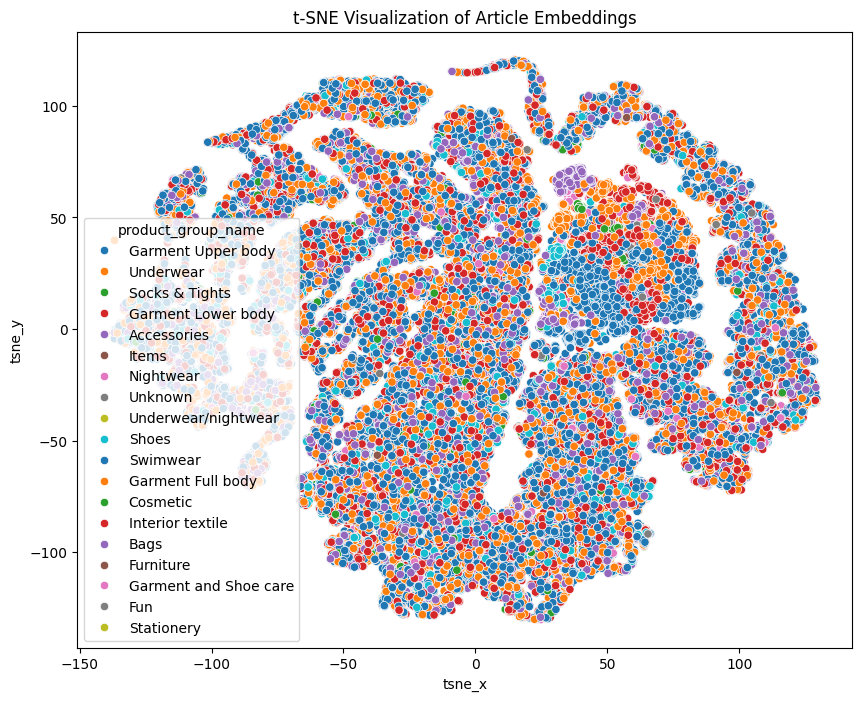

In [54]:
embeddings = model(torch.tensor(np.stack(articles_with_images['combined_features'].values), dtype=torch.float32), edge_index).cpu().detach().numpy()
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

articles_with_images['tsne_x'] = reduced_embeddings[:, 0]
articles_with_images['tsne_y'] = reduced_embeddings[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='product_group_name', data=articles_with_images, palette='tab10')
plt.title('t-SNE Visualization of Article Embeddings')
plt.show()


In [58]:
# Example usage
customer_id = "00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657"  # Replace with a valid customer ID
recommendations = recommend_articles_for_customer(
    customer_id=customer_id,
    model=model,
    articles_with_images=articles_with_images,
    transactions_filtered=transactions_filtered,
    edge_index=edge_index,
    top_n=10
)

print("Recommendations for Customer ID", customer_id)
print(recommendations)


Recommendations for Customer ID 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
        article_id                    prod_name
65569   0746308012                     BOAZ L/S
85334   0820960002                  Molly dress
86114   0824337002  Perrie Slim HW Denim Shorts
72912   0771596001                        Naomi
93887   0861847004                        Fiona
102331  0906393005                       Alicia
38412   0659146005                   Tyko fancy
95584   0868680006           Tina creasing tank
67320   0751994024           Slim 5pkt Midprice
47094   0689011012              Joe chino TP(1)
